## Creating Helper Functions

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


 ## Selecting New Albums to Purchase

In [5]:
albums_sold_usa = '''
WITH albums_usa AS (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i on il.invoice_id = i.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country = "USA"
)

SELECT g.name as genre, 
       count(au.invoice_line_id) tracks_sold,
       CAST(count(au.invoice_line_id) AS FLOAT)/
        (SELECT count(*) FROM albums_usa) as percent_sold
FROM albums_usa au
INNER JOIN track t on t.track_id = au.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
Group By g.name
Order by tracks_sold DESC
LIMIT 10
;
'''

In [6]:
run_query(albums_sold_usa)

,genre,tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


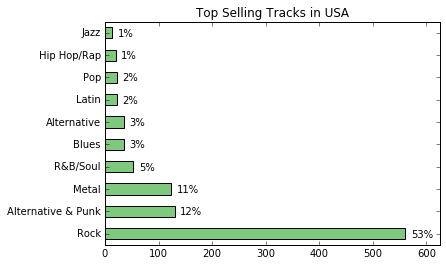

In [7]:
genre_sales_usa = run_query(albums_sold_usa)
genre_sales_usa.set_index('genre', inplace=True, drop = True)

genre_sales_usa['tracks_sold'].plot.barh(
    title = 'Top Selling Tracks in USA',
    xlim=(0, 625),
    colormap = plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'tracks_sold']
    percent = (genre_sales_usa.loc[label,'percent_sold'] * 100
              ).astype(int).astype(str) + '%'
    plt.annotate(str(percent), (score + 10, i - 0.15 ))
    
    
plt.show()


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

Red Tone (Punk)
Slim Jim Bites (Blues)
Meteor and the Girls (Pop)
It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

In [8]:
# employee_sales_performance = '''
# SELECT e.first_name ||" "||e.last_name as name,
# e.hire_date,
# sum(i. total) as total_price
# FROM employee e
# JOIN customer c on e.employee_id = c.support_rep_id
# JOIN invoice i on c.customer_id = i.customer_id
# Group By 1,2
# ;
# '''
# run_query(employee_sales_performance)

In [9]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS (
SELECT 
    i.customer_id,
    c.support_rep_id, 
    SUM(i.total) total
FROM customer c
JOIN invoice i on c.customer_id = i.customer_id
GROUP BY 1,2
)

SELECT
e.first_name ||" "||e.last_name as name,
e.hire_date,
SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
JOIN employee e on e.employee_id = csrs.support_rep_id
GROUP BY 1,2
;
'''

run_query(employee_sales_performance)

,name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


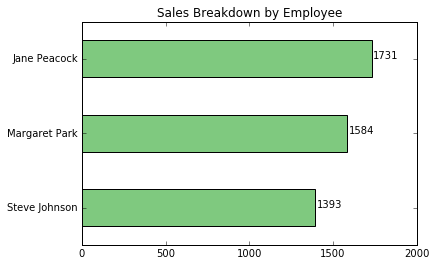

In [10]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index('name', inplace=True, drop = True)
employee_sales.sort_values('total_sales', inplace=True)

employee_sales['total_sales'].plot.barh(
    legend = False,
    title='Sales Breakdown by Employee',
    xlim = (0,2000),
    colormap = plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(employee_sales.index)):
    sale = employee_sales.loc[label,'total_sales']
    plt.annotate(str(int(sale)) , (sale + 10, i))
    

plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates

## Analyzing Sales by Country

In [11]:
sales_by_country = '''
WITH country_or_other AS (
SELECT 
    CASE 
        WHEN (SELECT COUNT(*) FROM customer where country=c.country) = 1 
        THEN "Other" 
        ELSE c.country END as country,
    c.customer_id,
    il.*
FROM invoice_line il
JOIN invoice i on i.invoice_id = il.invoice_id
JOIN customer c on c.customer_id = i.customer_id
)

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT 
        country,
        COUNT(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE WHEN country = 'Other' THEN 1 ELSE 0 END AS sort
    FROM country_or_other
    Group By country
    Order By sort ASC, total_sales DESC
)
;
'''


run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [12]:
# sales_by_country = '''
# WITH country_or_other AS (
# SELECT 
#     CASE 
#         WHEN (SELECT COUNT(*) FROM customer where country=c.country) = 1 
#         THEN "Other" 
#         ELSE c.country END as country
#     c.customer_id,
#     il.*
# FROM invoice_line il
# JOIN invoice i on i.invoice_id = il.invoice_id
# JOIN customer c on c.customer_id = i.customer_id
# )

# '''


# run_query(sales_by_country)

## Visualizing Sales by Country

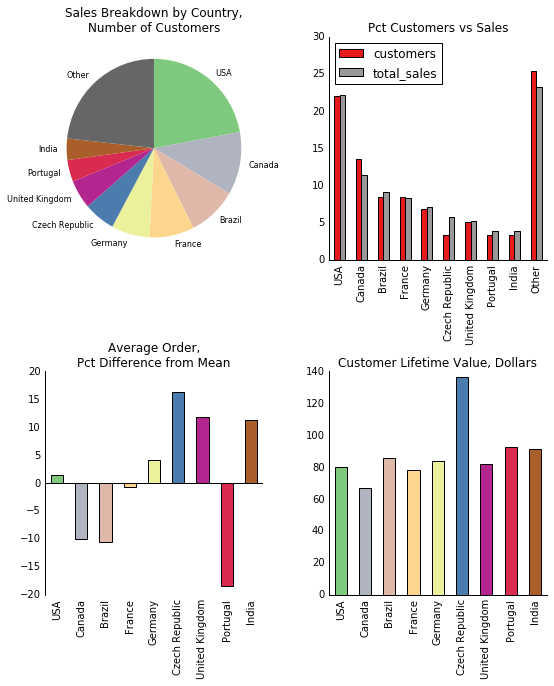

In [13]:
country_metrics = run_query(sales_by_country)

country_metrics.set_index("country", inplace=True, drop=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))

ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=.3)

# top left

sales_breakdown = country_metrics['total_sales'].copy().rename('')

sales_breakdown.plot.pie(
    ax = ax1,
    startangle = 90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)


# top right
columns = [ "customers", "total_sales"]
custs_v_sales = country_metrics[columns].copy()
custs_v_sales.index.name = ''

for c in columns:
    custs_v_sales[c] /= custs_v_sales[c].sum() / 100
    
custs_v_sales.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)

ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name = ''

difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('Other', inplace=True)

difference_from_avg.plot.bar(
    ax=ax3,
    title = "Average Order,\nPct Difference from Mean",
    color=colors
)

ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()



Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [28]:
albums_vs_tracks = '''
WITH invoice_first_track AS (
        SELECT
            invoice_id,
            MIN(track_id) as first_track_id
        FROM invoice_line 
        GROUP BY invoice_id
)

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM
(
    SELECT
        ifs.*,
        CASE WHEN 
            (
            SELECT t.track_id 
            FROM track t
            WHERE t.album_id = 
                            (
                            SELECT t2.album_id 
                            FROM track t2 
                            WHERE t2.track_id = ifs.first_track_id
                            )
            EXCEPT
                SELECT il2.track_id 
                FROM invoice_line il2
                WHERE il2.invoice_id = ifs.invoice_id
            ) IS NULL

            AND
             (
             SELECT il2.track_id 
             FROM invoice_line il2
             WHERE il2.invoice_id = ifs.invoice_id

             EXCEPT

             SELECT t.track_id 
             FROM track t
             WHERE t.album_id = (
                                 SELECT t2.album_id 
                                 FROM track t2
                                 WHERE t2.track_id = ifs.first_track_id
                                 ) 
             ) IS NULL


            THEN "yes" ELSE "no" END AS album_purchase
    FROM invoice_first_track ifs
)
GROUP BY album_purchase
;

'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.